# Reconstruction vis Deformation
Pointcloud to mesh reconstruction via retrieval and deformation

In [1]:
# load libraries
import trimesh
import torch
import json
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from types import SimpleNamespace
from utils import render
from shapenet_dataloader import ShapeNetMesh, FixedPointsCachedDataset
from deepdeform.layers.deformation_layer import NeuralFlowDeformer
from deepdeform.layers.embedding_layer import LatentEmbedder
import deepdeform.utils.train_utils as utils
from torch.utils.data import DataLoader
import pickle
import time
from utils import render

### Options

In [2]:
# choice of checkpoint to load
run_dir = "runs/pretrained_symm128"
checkpoint = "checkpoint_latest.pth.tar_deepdeform_100.pth.tar"
device = torch.device("cuda")

### Setup

In [3]:
# load training args
args = SimpleNamespace(**json.load(open(os.path.join(run_dir, 'params.json'), 'r')))

# setup model
deformer = NeuralFlowDeformer(latent_size=args.lat_dims, f_width=args.deformer_nf, s_nlayers=2, 
                              s_width=5, method=args.solver, nonlinearity=args.nonlin, arch='imnet',
                              adjoint=args.adjoint, rtol=args.rtol, atol=args.atol, via_hub=True,
                              no_sign_net=(not args.sign_net), symm_dim=(2 if args.symm else None))
lat_params = torch.nn.Parameter(torch.randn(4746, args.lat_dims)*1e-1, requires_grad=True)
deformer.add_lat_params(lat_params)
deformer.to(device)

# load checkpoint
resume_dict = torch.load(os.path.join(run_dir, checkpoint))
start_ep = resume_dict["epoch"]
global_step = resume_dict["global_step"]
tracked_stats = resume_dict["tracked_stats"]
deformer.load_state_dict(resume_dict["deformer_state_dict"])

# dataloader
data_root = args.data_root.replace('shapenet_watertight', 'shapenet_simplified')
mesh_dataset = ShapeNetMesh(data_root=data_root, split="train", category="chair", 
                            normals=False)
point_dataset = FixedPointsCachedDataset("data/shapenet_train.pkl", npts=512)

## Sample inputs and visualize

In [4]:
# take a sample point cloud from a shape
p = pickle.load(open("data/shapenet_val.pkl", "rb"))
name = list(p.keys())[0]
input_points = p[name]
mesh_gt = trimesh.load("data/shapenet_watertight/"+name+"/model_occnet.ply")

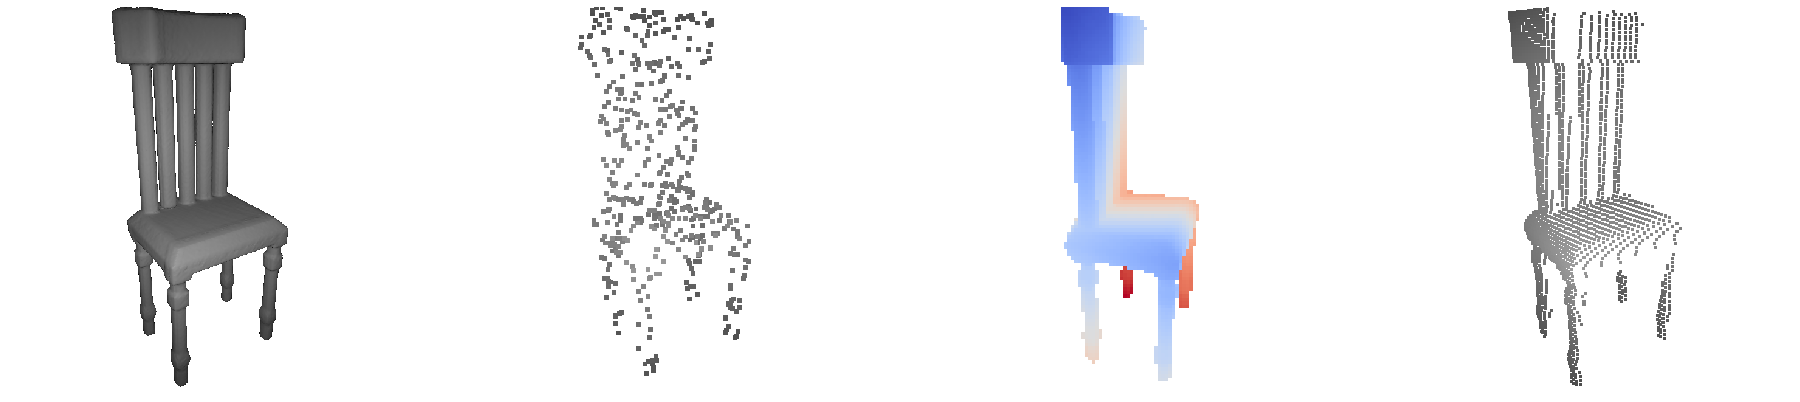

In [26]:
# view point
eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]

def rgb2rgba(rgb):
    """remove white background."""
    rgb = rgb.copy() / 255.
    alpha = np.linalg.norm(1-rgb, axis=-1) != 0
    alpha = alpha.astype(np.float32)[..., None]
    rgba = np.concatenate([rgb, alpha], axis=-1)
    return rgba

# subsample points
point_subsamp = mesh_gt.sample(512)

img_mesh, _, _, _ = render.render_trimesh(mesh_gt, eye_1, center, up, light_intensity=3)
img_pt_sub, _, _, _ = render.render_trimesh(trimesh.PointCloud(point_sub), 
                                            eye_1, center, up, light_intensity=3, point_size=8)
# virtual scan (view 2) and unproject depth
_, scan_depth, world2cam, cam2img = render.render_trimesh(mesh_gt, eye_2, center, up, res=(112, 112))
points_unproj = render.unproject_depth_img(scan_depth, cam2img, world2cam)
img_pt_dep, _, _, _ = render.render_trimesh(trimesh.PointCloud(points_unproj), 
                                            eye_1, center, up, light_intensity=3, point_size=5)

size_per_fig = 8
fig, axes = plt.subplots(figsize=(size_per_fig*4, size_per_fig), ncols=4)
axes[0].imshow(rgb2rgba(img_mesh))
axes[0].axis('off')
# axes[0].set_title("Ground Truth Mesh")

axes[1].imshow(rgb2rgba(img_pt_sub))
axes[1].axis('off')
# axes[1].set_title("Sparse Point Samples")

d = scan_depth.copy()
d[scan_depth==0] = np.nan
axes[2].imshow(d, cmap='coolwarm')
axes[2].axis('off')
# axes[2].set_title("Depth Scan")

axes[3].imshow(rgb2rgba(img_pt_dep))
axes[3].axis('off')
# axes[3].set_title("Scanned Points (view 1)")

plt.show()

### Optimize for the latent code corresponding to point observations

In [ ]:
embedder = LatentEmbedder(point_dataset, mesh_dataset, deformer)

In [ ]:
inputs = input_points[:512]
input_pts = torch.tensor(input_points[:512])[None].to(device)
lat_codes = embedder.embed(input_pts, matching="two_way", verbose=True, lr=1e-2, niter=40, bs=32, seed=1)

In [ ]:
# np.save("lat_codes_tune.npy", lat_codes)
# lat_codes = np.load("lat_codes_tune.npy")

In [ ]:
# retrieve, save results
deformed_meshes, orig_meshes, dist = embedder.retrieve(lat_codes, tar_pts=inputs, matching="two_way", topk=5)

In [ ]:
# pick_idx = np.argmin(dist)
pick_idx = 4
v, f = deformed_meshes[pick_idx]
mesh = trimesh.Trimesh(v, f)
vo, fo = orig_meshes[pick_idx]
mesh_o = trimesh.Trimesh(vo, fo)
img_orig, _ = render.render_trimesh(mesh_o.copy(), color=[1.,1.,1.], res=(512,512))
img_def, _ = render.render_trimesh(mesh.copy(), inputs, pts_colors=[1., 1., 0.], pts_scale=0.005, color=[1.,1.,1.], res=(512,512))
img_gt, _ = render.render_trimesh(mesh_gt.copy(), color=[1.,1.,1.], res=(512,512))
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 6))
axes[0].imshow(img_orig)
axes[0].axis('off')
axes[0].set_title("Retrieved Shape")
axes[1].imshow(img_def)
axes[1].axis('off')
axes[1].set_title("Deformed Shape")
axes[2].imshow(img_gt)
axes[2].axis('off')
axes[2].set_title("GT Shape")
plt.show()

In [ ]:
# meshes_ = meshes[0]
# os.makedirs("retrieval", exist_ok=True)
# # save point cloud
# pc = np.savetxt("retrieval/input_points.xyz", inputs, delimiter=' ')
# for idx, (v, f) in enumerate(meshes_):
#     m = trimesh.Trimesh(v, f)
#     m.export(f"retrieval/mesh_{idx}.ply")